In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from random import randint
import cellpylib as cpl
import matplotlib.pyplot as plt
from tensorflow.keras import layers


In [3]:
IMAGE_SIZE = 64

In [4]:
def run_ca(rule_number, plot=False, save=False):
    cellular_automaton = cpl.init_simple(IMAGE_SIZE)  
    cellular_automaton = cpl.evolve(cellular_automaton, timesteps=IMAGE_SIZE, memoize=True,
                                    apply_rule=lambda n, c, t: cpl.nks_rule(n, rule_number))
    if plot:
        cpl.plot(cellular_automaton)
    if save:
        path = './nks/' + str(rule_number) 
        Path(path).mkdir(parents=True, exist_ok=True)
        plt.imsave(path + '/out.png', cellular_automaton, cmap='binary')

In [64]:
for i in range(0, 256):
    run_ca(i, save=True)

In [50]:
dataset = keras.preprocessing.image_dataset_from_directory("./nks", image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=32, color_mode='grayscale', seed=123)
# print first few entries
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

Found 256 files belonging to 256 classes.
(32, 64, 64, 1)
[103 128  20  53  51  28   1 161   2  70  37 251 250 156  80 216 239 201
 177  87 253 149 255 133 221   0  91  65  81  82 214 236]


In [51]:
dataset = dataset.prefetch(buffer_size=32)

In [52]:
# create model
model = keras.Sequential([
    # CenterCrop(48, 48),
    # Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Flatten(),
    # classification layer
    layers.Dense(256, activation='softmax')
])

# compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# train model
model.fit(dataset, epochs=300)

Epoch 1/300
8/8 [==============================] - 1s 5ms/step - loss: 6.3483 - accuracy: 0.0000e+00
Epoch 2/300
8/8 [==============================] - 0s 5ms/step - loss: 5.4089 - accuracy: 0.0469
Epoch 3/300
8/8 [==============================] - 0s 5ms/step - loss: 4.8493 - accuracy: 0.0977
Epoch 4/300
8/8 [==============================] - 0s 5ms/step - loss: 3.8987 - accuracy: 0.1523
Epoch 5/300
8/8 [==============================] - 0s 5ms/step - loss: 3.1009 - accuracy: 0.2617
Epoch 6/300
8/8 [==============================] - 0s 5ms/step - loss: 2.5207 - accuracy: 0.3945
Epoch 7/300
8/8 [==============================] - 0s 5ms/step - loss: 2.1483 - accuracy: 0.3867
Epoch 8/300
8/8 [==============================] - 0s 5ms/step - loss: 1.9240 - accuracy: 0.4336
Epoch 9/300
8/8 [==============================] - 0s 5ms/step - loss: 1.7703 - accuracy: 0.4531
Epoch 10/300
8/8 [==============================] - 0s 5ms/step - loss: 1.7153 - accuracy: 0.4375
Epoch 11/300
8/8 [=======

In [53]:
# save model
model.save('nks.h5')

In [54]:
# load model
model = keras.models.load_model('nks.h5')

# test model
test_dataset = keras.preprocessing.image_dataset_from_directory("./nks", image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=32, color_mode='grayscale',seed=123)
model.evaluate(test_dataset)

Found 256 files belonging to 256 classes.
8/8 [==============================] - 0s 3ms/step - loss: 1.1090 - accuracy: 0.5625


[1.1089532375335693, 0.5625]

In [55]:
# predict
predictions = model.predict(test_dataset)
print(np.argmax(predictions, axis=1))
# print true labels
for image_batch, labels_batch in test_dataset.take(1):
    print(labels_batch.numpy())
    

8/8 [==============================] - 0s 2ms/step
[ 30  51  21  55 143 176  51  36  36  36 167 103 215 154  36  85 155  36
  20  64  87 188  93  51  74 189 198  50  51  45 195  78  90   0  55  90
 195 107 159  97   0 195   0  36  76  89 205  97  15  36 147 195 138  14
 170 179  36  97 233 110   0   0   0 181 188  99 223 134 161 136  45  51
  58 103  19  43 164 222  90 195 135 195  97  63  64  65 232  29   0 187
  17 163 181  20 241  36  51  51 255 225  51 195 117 103  97 247 195 141
 109  51 181  52 103 195  34 181 206 102 173  51  61 201 203 245 124 150
 145 250   0 183 101  55 240  97 103 121 110 180 126  97 103 218 195  17
 100   6  12  57  51 103 156  48 188 213  36  92   0 178   0 195   0 137
 181 155  28  36  26  90 195  34  49 132 200  83  36  90  54  49 195  13
  55 214  36 229 249 159  41  51 181 168  51 195  97 148  98  66   8 253
 111 196 188 119  13 238 231 244  37  90 227 195  90 136 172  49  31  56
   0 128   0  36 152 129 192  35 209  20  96  49 211  51 181 105  72 200


[226  11  49 245 197 124  18 238 157  96  16   9 232 100 113 248  92  57
  24  25  60 145 201  65 132 175  35 218  17 179 224  44]


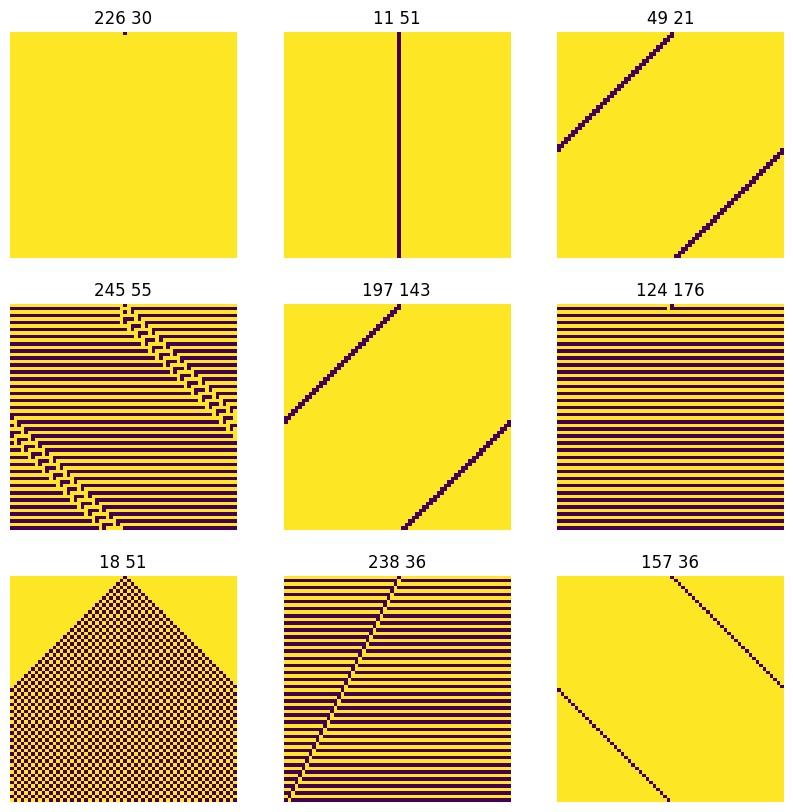

In [57]:
# plot the labels in the validation set, and the predictions
for image_batch, labels_batch in test_dataset.take(1):
    print(labels_batch.numpy())
    # plot the first 9 images
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(str(labels_batch[i].numpy().astype("uint8")) + " " + str(np.argmax(predictions[i])))
        plt.axis("off")


In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1
